## Data Collection and Preparation

### Import Libraries

In [11]:
import pandas as pd
import numpy as np
import datetime
import ast
import pytz

### Import Data

In [17]:
charging_sessions_data = pd.read_csv("charging_sessions.csv")
weather_data = pd.read_csv("weather_burbank_airport.csv")

In [ ]:
charging_sessions_data.head(5)

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil..."
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil..."
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil..."


### Data Cleaning
1. **Delete irrelevant data**
* Check for irrelevant attributes/ colum
2. **Check for appropriate format**
* Check for correct attribute type/ format
* Change UTC format to corresponding timezone
3. **Check for erroneous data**
* Check for duplicates
* Check for null values
* Check for uniqueness (e.g. id)
* Check that all data lies around the same year span
* Check that the datetime objects are logical (e.g. connectionTime should be earlier than disconnectTime)
* Check for outliers
4. **Add missing attributes**
* Upon comparison some attributes are missing that can be found in the UserInput column

### 1. Charging Session Data Preparation

#### 1.1. Delete irrelevant columns

In [ ]:
charging_sessions_data.columns

Index(['Unnamed: 0', 'id', 'connectionTime', 'disconnectTime',
       'doneChargingTime', 'kWhDelivered', 'sessionID', 'siteID', 'spaceID',
       'stationID', 'timezone', 'userID', 'userInputs'],
      dtype='object')

In [ ]:
# delete column of attribute "Unnamed: 0" since it serves no purpose and is not mentioned in the team assignment pdf
charging_sessions_data = charging_sessions_data.drop(columns=["Unnamed: 0"])

In [ ]:
charging_sessions_data.columns

Index(['id', 'connectionTime', 'disconnectTime', 'doneChargingTime',
       'kWhDelivered', 'sessionID', 'siteID', 'spaceID', 'stationID',
       'timezone', 'userID', 'userInputs'],
      dtype='object')

#### 1.2. Check for appropriate format

In [ ]:
# check types
charging_sessions_data.dtypes

id                   object
connectionTime       object
disconnectTime       object
doneChargingTime     object
kWhDelivered        float64
sessionID            object
siteID                int64
spaceID              object
stationID            object
timezone             object
userID              float64
userInputs           object
dtype: object

In [ ]:
# convert attributes into the right format

# convert to string
charging_sessions_data["id"] = charging_sessions_data["id"].astype("string")
charging_sessions_data["sessionID"] = charging_sessions_data["sessionID"].astype("string")
charging_sessions_data["siteID"] = charging_sessions_data["siteID"].astype("string")
charging_sessions_data["spaceID"] = charging_sessions_data["spaceID"].astype("string")
charging_sessions_data["stationID"] = charging_sessions_data["stationID"].astype("string")
charging_sessions_data["timezone"] = charging_sessions_data["timezone"].astype("string")
charging_sessions_data["userID"] = charging_sessions_data["userID"].astype("string")
charging_sessions_data["userInputs"] = charging_sessions_data["userInputs"].astype("string")

# convert to datetime
charging_sessions_data["connectionTime"] = pd.to_datetime(charging_sessions_data["connectionTime"])
charging_sessions_data["disconnectTime"] = pd.to_datetime(charging_sessions_data["disconnectTime"])
charging_sessions_data["doneChargingTime"] = pd.to_datetime(charging_sessions_data["doneChargingTime"])

charging_sessions_data.dtypes

id                       string[python]
connectionTime      datetime64[ns, UTC]
disconnectTime      datetime64[ns, UTC]
doneChargingTime    datetime64[ns, UTC]
kWhDelivered                    float64
sessionID                string[python]
siteID                   string[python]
spaceID                  string[python]
stationID                string[python]
timezone                 string[python]
userID                   string[python]
userInputs               string[python]
dtype: object

In [ ]:
# Function to convert UTC timestamps to the specified time zone
def convert_to_timezone(df, time_column, timezone_column):
    """
    Converts a UTC timestamp column to the corresponding local timezone.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        time_column (str): The name of the column with UTC timestamps.
        timezone_column (str): The name of the column with timezone strings.

    Returns:
        list: A list of timestamps converted to their respective time zones.
    """
    local_times = []
    for utc_time, tz in zip(df[time_column], df[timezone_column]):
        try:
            # Ensure the timestamp is in UTC
            utc_time = utc_time.tz_localize('UTC') if utc_time.tzinfo is None else utc_time
            # Convert to the local timezone
            local_timezone = pytz.timezone(tz)
            local_time = utc_time.astimezone(local_timezone)
            local_times.append(local_time)
        except Exception as e:
            # Handle errors gracefully
            print(f"Error converting time {utc_time} with timezone {tz}: {e}")
            local_times.append(None)
    return local_times

# Apply the conversion function to relevant columns
charging_sessions_data['connectionTime_local'] = convert_to_timezone(
    charging_sessions_data, 'connectionTime', 'timezone'
)
charging_sessions_data['disconnectTime_local'] = convert_to_timezone(
    charging_sessions_data, 'disconnectTime', 'timezone'
)
charging_sessions_data['doneChargingTime_local'] = convert_to_timezone(
    charging_sessions_data, 'doneChargingTime', 'timezone'
)

# Inspect the results
print(charging_sessions_data[['connectionTime', 'connectionTime_local', 'timezone']].head())

Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with

#### 1.3. Check erroneous data

##### Check for duplicates & delete them

In [ ]:
# Check for duplicates
duplicated_lines = charging_sessions_data[charging_sessions_data.duplicated()]
if duplicated_lines.empty:
    print("No duplicates found")
else: print("Duplicates found")
       

Duplicates found


In [ ]:
charging_sessions_data = charging_sessions_data.drop_duplicates(keep='first')

In [ ]:
# Control if duplicates have been removed
duplicated_lines = charging_sessions_data[charging_sessions_data.duplicated()]
if duplicated_lines.empty:
    print("No duplicates found")
else: print("Duplicates found")

No duplicates found


##### Check for null values (in whole lines and also within certain columns)

In [ ]:
# Check for null values in lines
lines_only_null_or_nan = (charging_sessions_data.isna() | (charging_sessions_data == 0)).all(axis=1)

# Check if there are lines that only contain the values '0' or 'NaN'.
if lines_only_null_or_nan.any():
    print("There are lines that only contain the values '0' or 'NaN'.")
else:
    print("There are NO lines that only contain the values '0' or 'NaN'.")

There are NO lines that only contain the values '0' or 'NaN'.


In [ ]:
# Filter lines in which the ‘kWhDelivered’ column has the value 0
zero_values = charging_sessions_data[charging_sessions_data['kWhDelivered'] == 0]

# Check if such lines exist and print them
if not zero_values.empty:
    print("There are lines in which the ‘kWhDelivered’ column contains the value 0:")
    print(zero_values)
else:
    print("There are NO lines in which the ‘kWhDelivered’ column contains the value 0.")

# Filter lines in which the ‘kWhDelivered’ column has the value NaN
nan_values = charging_sessions_data[charging_sessions_data['kWhDelivered'].isna()]

# Check if such lines exist and print them
if not nan_values.empty:
    print("There are lines in which the ‘kWhDelivered’ column contains the value 'NaN':")
    print(nan_values)
else:
    print("There are NO lines in which the ‘kWhDelivered’ column contains the value 'NaN'")

# Filter lines in which the ‘kWhDelivered’ column has negative values
negative_values = charging_sessions_data[charging_sessions_data['kWhDelivered'] < 0]

# Check if such lines exist and print them
if not negative_values.empty:
    print("There are lines in which the ‘kWhDelivered’ column contains negative values:")
    print(negative_values)
else:
    print("There are NO lines in which the ‘kWhDelivered’ column contains negative values.")


There are NO lines in which the ‘kWhDelivered’ column contains the value 0.
There are NO lines in which the ‘kWhDelivered’ column contains the value 'NaN'
There are NO lines in which the ‘kWhDelivered’ column contains negative values.


In [ ]:
# Filter lines in which the ‘connectionTime’ column has the value "NaT"
nat_values = charging_sessions_data[charging_sessions_data['connectionTime'].isna()]

# Check if such lines exist and print them
if not nat_values.empty:
    print("There are lines in which the ‘connectionTime’ column contains the value NaT:")
    print(nat_values)
else:
    print("There are NO lines in which the ‘connctionTime’ column contains the value NaT.")

# Filter lines in which the ‘diconnectTime’ column has the value "NaT"
nat_values = charging_sessions_data[charging_sessions_data['disconnectTime'].isna()]

# Check if such lines exist and print them
if not nat_values.empty:
    print("There are lines in which the ‘disconnectTime’ column contains the value NaT:")
    print(nat_values)
else:
    print("There are NO lines in which the ‘diconnectTime’ column contains the value NaT.")

# Filter lines in which the ‘doneChargingTime’ column has the value "NaT"
nat_values = charging_sessions_data[charging_sessions_data['doneChargingTime'].isna()]

# Check if such lines exist and print them
if not nat_values.empty:
    print("There are lines in which the ‘doneChargingTime’ column contains the value NaT:")
  
else:
    print("There are NO lines in which the ‘doneChargingTime’ column contains the value NaT.")

print("Amount:")
print(len(nat_values))


There are NO lines in which the ‘connctionTime’ column contains the value NaT.
There are NO lines in which the ‘diconnectTime’ column contains the value NaT.
There are lines in which the ‘doneChargingTime’ column contains the value NaT:
Amount:
4087


##### Check for uniqueness

In [ ]:
# Check for uniqueness in column 'id'
if charging_sessions_data['id'].duplicated().any():
    print("The ‘id’ column contains duplicate values.")
else:
    print("The ‘id’ column only contains unique values.")


The ‘id’ column only contains unique values.


In [ ]:
# Check for uniqueness in column 'sessionID'
if charging_sessions_data['sessionID'].duplicated().any():
    print("The ‘sessionID’ column contains duplicate values.")
else:
    print("The ‘sessionID’ column only contains unique values.")


The ‘sessionID’ column only contains unique values.


##### Check that the time details are in the correct order

In [ ]:
# Check that doneChargingTime is not earlier than or the same as connectionTime
# Print length of data frame to compare later
print(len(charging_sessions_data))

65037


In [ ]:
# Check if doneChargingTime is later than connectionTime
if (charging_sessions_data['connectionTime'] <= charging_sessions_data['doneChargingTime']).all():
    print("The 'connectionTime' is always earlier than 'doneChargingTime'.")
else:
    print("There is at least one line where 'connectionTime' is not earlier than 'doneChargingTime'.")

There is at least one line where 'connectionTime' is not earlier than 'doneChargingTime'.


In [ ]:
# Filter the lines where connectionTime >= doneChargingTime
error_lines = charging_sessions_data[charging_sessions_data['connectionTime'] >= charging_sessions_data['doneChargingTime']]

if error_lines.any:
    print('There are error lines')
else: print('There are NO error lines')
    

# Test if there are error lines
if not error_lines.empty:
    print("There is at least one line where 'connectionTime' is later than 'doneChargingTime':")
    print(error_lines)
    
  # Delete error lines
    charging_sessions_data.drop(error_lines.index, inplace=True)
    print("Error lines have been deleted")
else:
    print("All lines are correct: 'connectionTime' is always earlier than 'doneChargingTime'.")

There are error lines
There is at least one line where 'connectionTime' is later than 'doneChargingTime':
                             id            connectionTime  \
22219  5c942ca4f9af8b06b04b3bb4 2019-03-05 19:13:55+00:00   
22253  5c957e1cf9af8b42f440af03 2019-03-06 20:26:30+00:00   
23562  5cca3a22f9af8b49aaa4cba0 2019-04-15 20:24:13+00:00   
23586  5ccb8ba6f9af8b4d9721df00 2019-04-16 16:11:08+00:00   
27689  5d856f1ff9af8b0c7bdf245c 2019-09-04 16:35:04+00:00   
27740  5d86c0a5f9af8b1022a81870 2019-09-05 18:44:57+00:00   
29295  5dcdffbdf9af8b220a19be8b 2019-10-29 17:22:32+00:00   
31285  5bc91740f9af8b0dc677b860 2018-05-04 19:08:37+00:00   
31287  5bc91740f9af8b0dc677b862 2018-05-04 19:23:52+00:00   
31398  5bc917d0f9af8b0dc677b8d1 2018-05-07 20:47:49+00:00   
31403  5bc917d0f9af8b0dc677b8d6 2018-05-07 20:47:51+00:00   
31407  5bc917d0f9af8b0dc677b8da 2018-05-07 20:47:55+00:00   
35840  5bc92c03f9af8b0dc677ca2b 2018-07-19 15:57:19+00:00   
38884  5bc937f6f9af8b0dc677d60f 2018-08-

In [ ]:
# Check whether there are errors after deletion
if (charging_sessions_data['connectionTime'] >= charging_sessions_data['doneChargingTime']).any():
    print("There are still error lines")
else:
    print("All error lines have been deleted.")

All error lines have been deleted.


In [ ]:
# Compare length of data frame
print(len(charging_sessions_data))

65008


In [ ]:
# Filter the lines where connectionTime >= doneChargingTime
error_line = charging_sessions_data[charging_sessions_data['connectionTime'] >= charging_sessions_data['doneChargingTime']]

# Test if there are error lines
if not error_line.empty:
    print("There is at least one line where 'connectionTime' is later than 'doneChargingTime':")
    print(error_line)
else:
    print("All lines are correct: 'connectionTime' always earlier than 'doneChargingTime'.")

All lines are correct: 'connectionTime' always earlier than 'doneChargingTime'.


In [ ]:
# Check if doneChargingTime is earlier than disconnectTime
if (charging_sessions_data['doneChargingTime'] < charging_sessions_data['disconnectTime']).all():
    print("The 'doneChargingTime' is always earlier than the 'disconnectTime'.")
else:
    print("There is at least one line where 'doneChargingTime' is not earlier than 'disconnectTime'.")

There is at least one line where 'doneChargingTime' is not earlier than 'disconnectTime'.


In [ ]:
# Filter the lines where doneChargingTime > disconnectTime
error_lines = charging_sessions_data[charging_sessions_data['doneChargingTime'] > charging_sessions_data['disconnectTime']]

if error_lines.any:
    print('There are error lines')
else: print('There are NO error lines')
    

# Test if there are error lines
if not error_lines.empty:
    print("There is at least one line where 'doneChargingTime' is later than 'disconnectTime':")
    print(error_lines)
    
  # Delete error lines
    charging_sessions_data.drop(error_lines.index, inplace=True)
    print("Error lines have been deleted")
else:
    print("All lines are correct: 'doneChargingTime' is always earlier than 'disconnectTime'.")

There are error lines
There is at least one line where 'doneChargingTime' is later than 'disconnectTime':
                             id            connectionTime  \
12     5e23b149f9af8b5fe4b973db 2020-01-02 15:04:38+00:00   
20     5e23b149f9af8b5fe4b973e3 2020-01-02 15:28:47+00:00   
25     5e23b149f9af8b5fe4b973e8 2020-01-02 15:42:05+00:00   
26     5e23b149f9af8b5fe4b973e9 2020-01-02 15:57:24+00:00   
33     5e23b149f9af8b5fe4b973f0 2020-01-02 16:34:35+00:00   
...                         ...                       ...   
65028  5d2fbdd3f9af8b4d0dd0d546 2019-07-01 19:20:31+00:00   
65030  5d2fbdd3f9af8b4d0dd0d548 2019-07-01 20:01:07+00:00   
65033  5d2fbdd3f9af8b4d0dd0d54b 2019-07-01 21:58:45+00:00   
65034  5d2fbdd3f9af8b4d0dd0d54c 2019-07-01 22:02:21+00:00   
65035  5d2fbdd3f9af8b4d0dd0d54d 2019-07-01 22:23:44+00:00   

                 disconnectTime          doneChargingTime  kWhDelivered  \
12    2020-01-02 22:08:39+00:00 2020-01-02 22:09:36+00:00        25.567   
20    2020-

In [ ]:
# Compare length of data frame
print(len(charging_sessions_data))

60621


In [ ]:
# Check that disconnectTime is not earlier than connectionTime
if (charging_sessions_data['connectionTime'] < charging_sessions_data['disconnectTime']).all():
    print("The 'connectionTime' is always earlier than the 'disconnectTime'.")
else:
    print("There is at least one line where 'connectionTime' is not earlier than 'disconnectTime'.")

The 'connectionTime' is always earlier than the 'disconnectTime'.


array([[<Axes: title={'center': 'connectionTime'}>,
        <Axes: title={'center': 'disconnectTime'}>,
        <Axes: title={'center': 'doneChargingTime'}>],
       [<Axes: title={'center': 'kWhDelivered'}>,
        <Axes: title={'center': 'connectionTime_local'}>,
        <Axes: title={'center': 'disconnectTime_local'}>],
       [<Axes: title={'center': 'doneChargingTime_local'}>, <Axes: >,
        <Axes: >]], dtype=object)

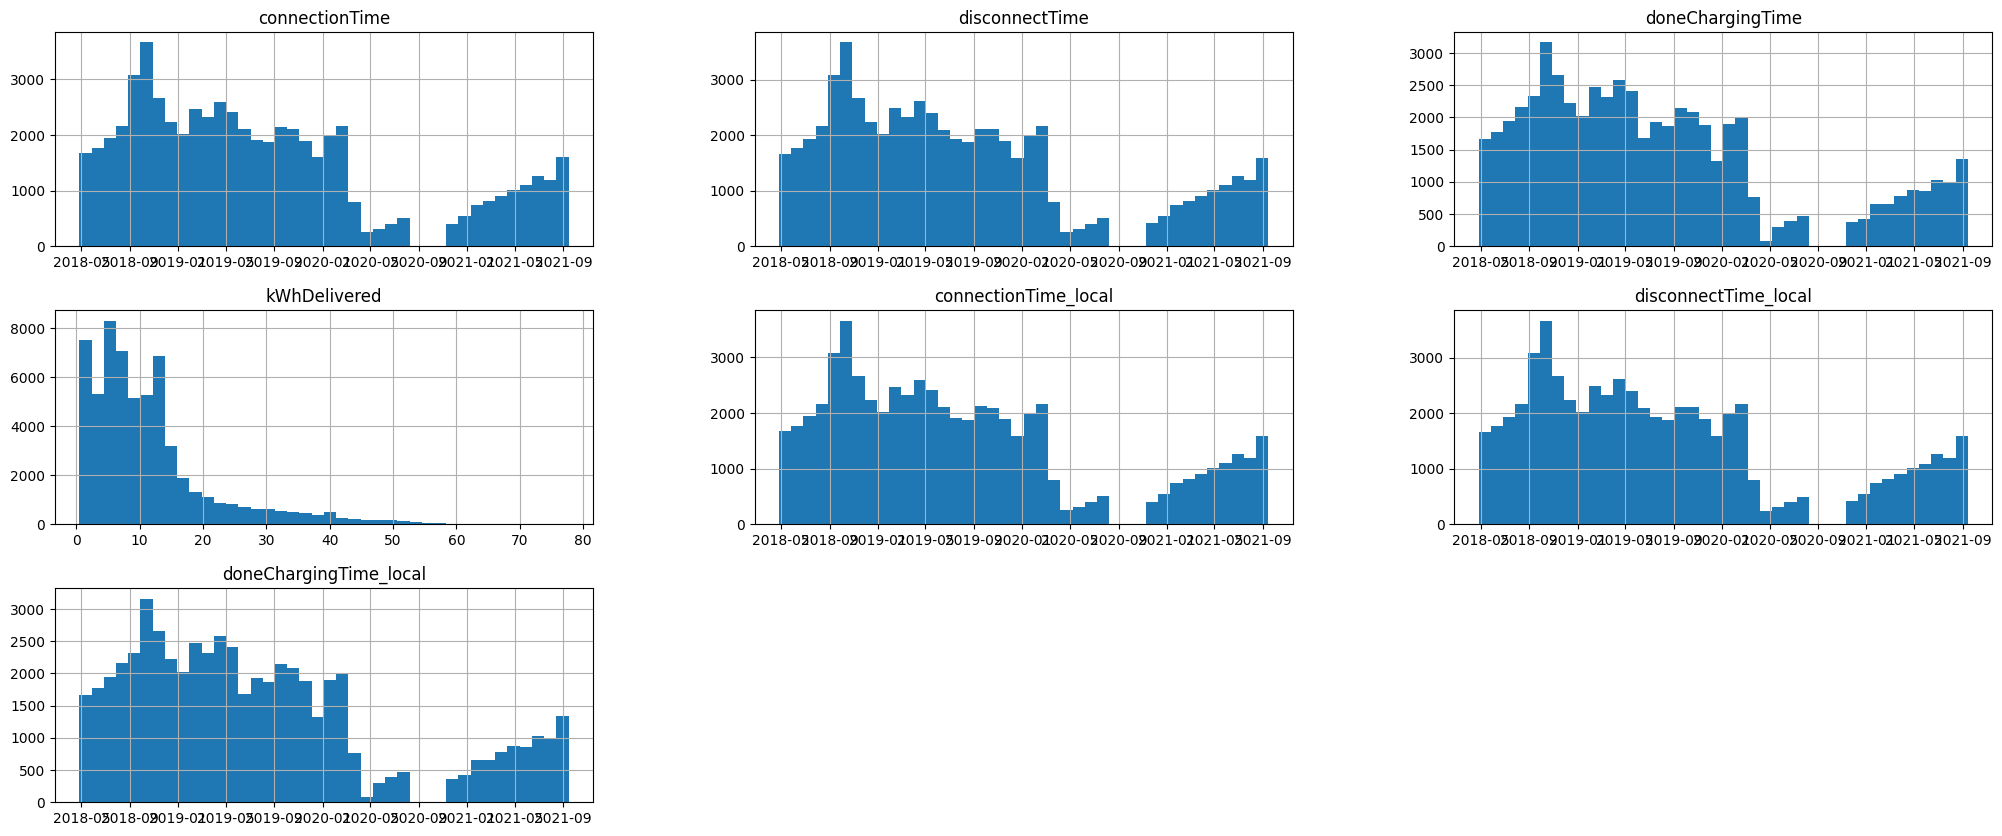

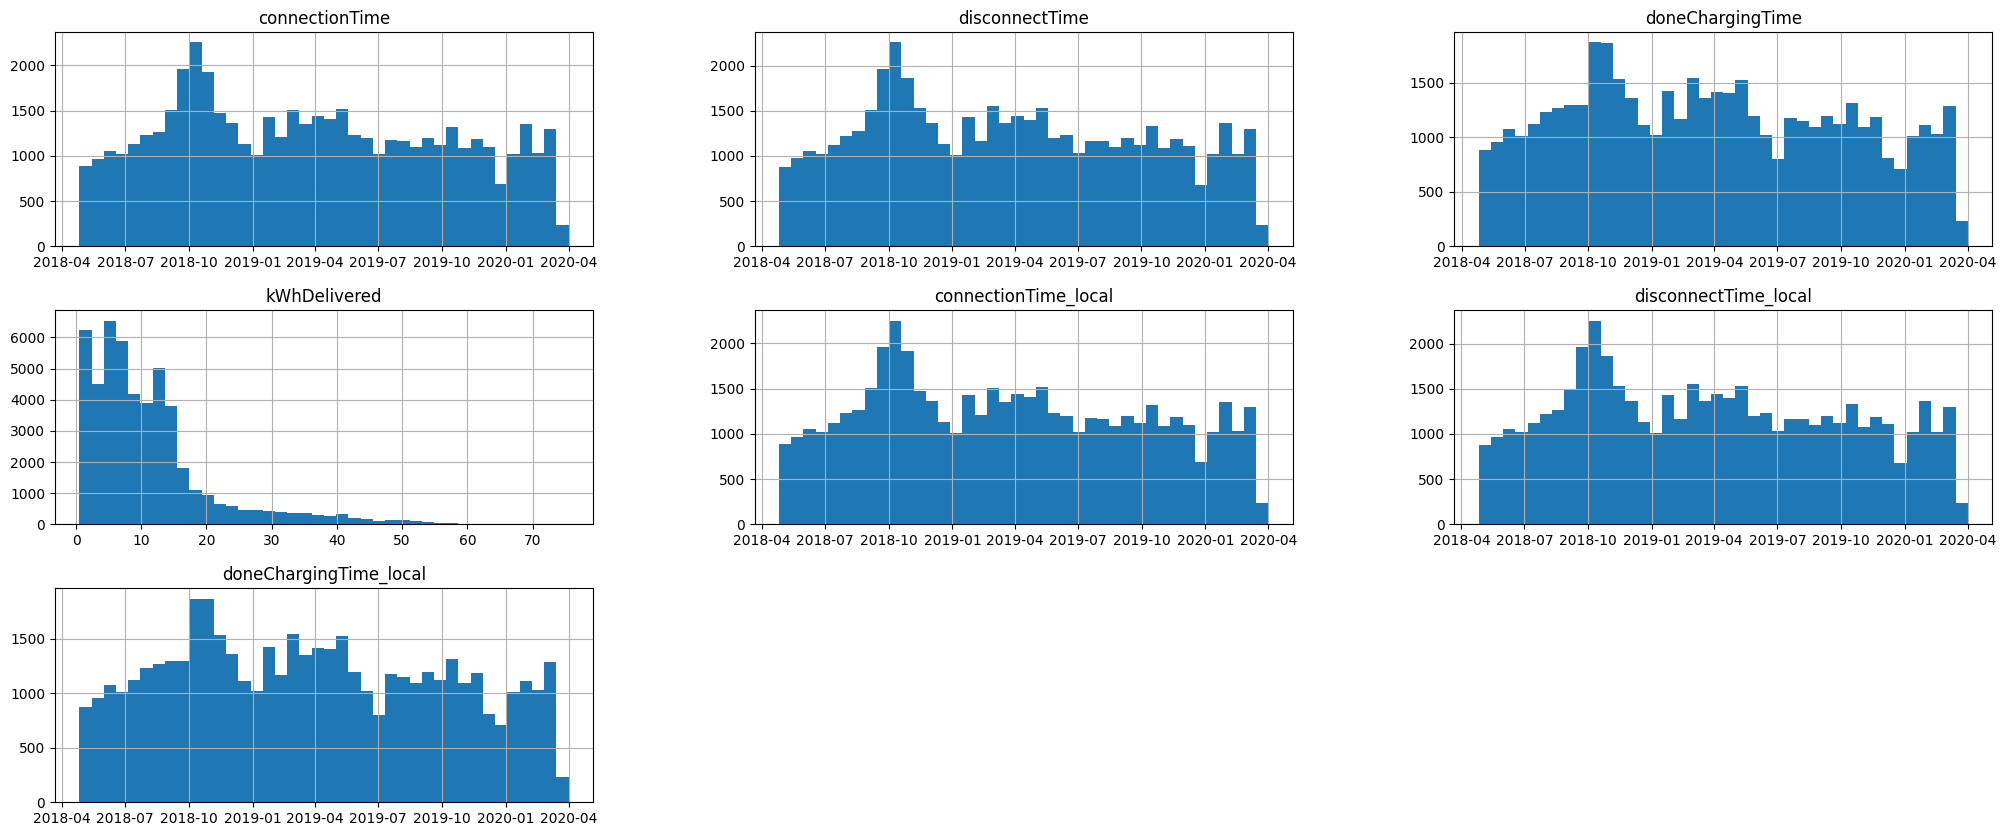

In [ ]:
# Check that all data lies around the same year span

# Plot the orginal data
charging_sessions_data.hist(bins=40, figsize=(25,10))
# We have decided to delete the data from 1 April 2020, as there are unusually few loans (April 2020 to September 2021) or even no data at all in between (September 2020 to January 2021).
# To avoid distortions, the data records will be deleted from 1 April 2020. Further analysis of the data is sufficient, as there are still enough data records available.

# Create a datetime object for April 1, 2020
cutoff_date = datetime.datetime(2020, 4, 1).replace(tzinfo=datetime.timezone.utc) # converted object cutoff in the same format as datetime64[ns, UTC]
# Keep only rows where the connectionTime is before the cutoff_date
charging_sessions_data = charging_sessions_data[charging_sessions_data['connectionTime'] < cutoff_date]
# The filtering condition (< cutoff_date) already ensures that both connectionTime and disconnectTime are before May 1st, 2020 (UTC)
# Show the plots
charging_sessions_data.hist(bins=40, figsize=(25,10))

#### 1.4. Add missing attributes

In [18]:
# let's convert user inputs in to list of dictionaries that we can access
def convertStringToList(data_string):
    # after removing missing values we wouldnt need this
    if pd.isna(data_string):
        return
# convert the string to a list (array)
    return ast.literal_eval(data_string)

# apply the funuction to all rows of userInputs
charging_sessions_data.userInputs = charging_sessions_data.userInputs.apply(lambda x: convertStringToList(x), 0)

def createUserInputColumn(columnName):
    charging_sessions_data[columnName] = None


createUserInputColumn("WhPerMile")
createUserInputColumn("kWhRequested")
createUserInputColumn("milesRequested")
createUserInputColumn("minutesAvailable")
createUserInputColumn("requestedDeparture")


def writeUserInput(input, columnName) :
     # we only consider the last user input
    if  isinstance(input,list) == False:
        return
    count = len(input) - 1 
    return input[count][columnName]

charging_sessions_data.WhPerMile = charging_sessions_data.userInputs.apply(lambda x : writeUserInput(x, 'WhPerMile'), 0)
charging_sessions_data.kWhRequested = charging_sessions_data.userInputs.apply(lambda x : writeUserInput(x, 'kWhRequested'), 0)
charging_sessions_data.milesRequested = charging_sessions_data.userInputs.apply(lambda x : writeUserInput(x, 'milesRequested'), 0)
charging_sessions_data.minutesAvailable = charging_sessions_data.userInputs.apply(lambda x : writeUserInput(x, 'minutesAvailable'), 0)
charging_sessions_data.requestedDeparture = charging_sessions_data.userInputs.apply(lambda x : writeUserInput(x, 'requestedDeparture'), 0)
# create a new table
user_input_table = charging_sessions_data[['userID', 'WhPerMile', 'kWhRequested','milesRequested','minutesAvailable','requestedDeparture']]

user_input_table.dtypes
user_input_table['requestedDeparture'] = pd.to_datetime(user_input_table['requestedDeparture']).copy()
user_input_table.head()

# charging_sessions_data.drop(['WhPerMile', 'kWhRequested','milesRequested','minutesAvailable','requestedDeparture', 'userInputs'], axis = 1)


/var/folders/nf/2xng7w014d1f2mbbxqsxbwg40000gn/T/ipykernel_26957/2871517723.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_input_table['requestedDeparture'] = pd.to_datetime(user_input_table['requestedDeparture']).copy()


,userID,WhPerMile,kWhRequested,milesRequested,minutesAvailable,requestedDeparture
0,194.0,250,25.0,100,463,2020-01-02 20:51:54+00:00
1,4275.0,280,70.0,250,595,2020-01-02 23:31:50+00:00
2,344.0,400,8.0,20,60,2020-01-02 14:56:35+00:00
3,1117.0,400,8.0,20,65,2020-01-02 15:04:58+00:00
4,334.0,400,16.0,40,504,2020-01-02 22:24:01+00:00


### Export Cleaned Data

In [19]:
charging_sessions_data.to_csv('cleaned_data.csv', index=False)
user_input_table.to_csv('registered_user_input.csv', index=False)

### Airport Weather Data Preparation

In [ ]:
weather_data

,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
0,Burbank,2018-01-01 08:53:00,9.0,33.0,Fair,991.75,9.0,0.0,8.0
1,Burbank,2018-01-01 09:53:00,9.0,33.0,Fair,992.08,0.0,0.0,9.0
2,Burbank,2018-01-01 10:53:00,9.0,21.0,Haze,992.08,0.0,0.0,9.0
3,Burbank,2018-01-01 11:53:00,9.0,29.0,Partly Cloudy,992.08,0.0,0.0,9.0
4,Burbank,2018-01-01 12:53:00,8.0,33.0,Fair,992.08,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...
29239,Burbank,2021-01-01 03:53:00,13.0,33.0,Fair,986.81,0.0,0.0,13.0
29240,Burbank,2021-01-01 04:53:00,12.0,33.0,Fair,986.81,11.0,0.0,12.0
29241,Burbank,2021-01-01 05:53:00,12.0,33.0,Fair,987.47,9.0,0.0,12.0
29242,Burbank,2021-01-01 06:53:00,11.0,33.0,Fair,987.14,13.0,0.0,11.0


#### Check for appropriate format

In [ ]:
weather_data.dtypes

city                        object
timestamp                   object
temperature                float64
cloud_cover                float64
cloud_cover_description     object
pressure                   float64
windspeed                  float64
precipitation              float64
felt_temperature           float64
dtype: object

array([[<Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'cloud_cover'}>],
       [<Axes: title={'center': 'pressure'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'precipitation'}>,
        <Axes: title={'center': 'felt_temperature'}>]], dtype=object)

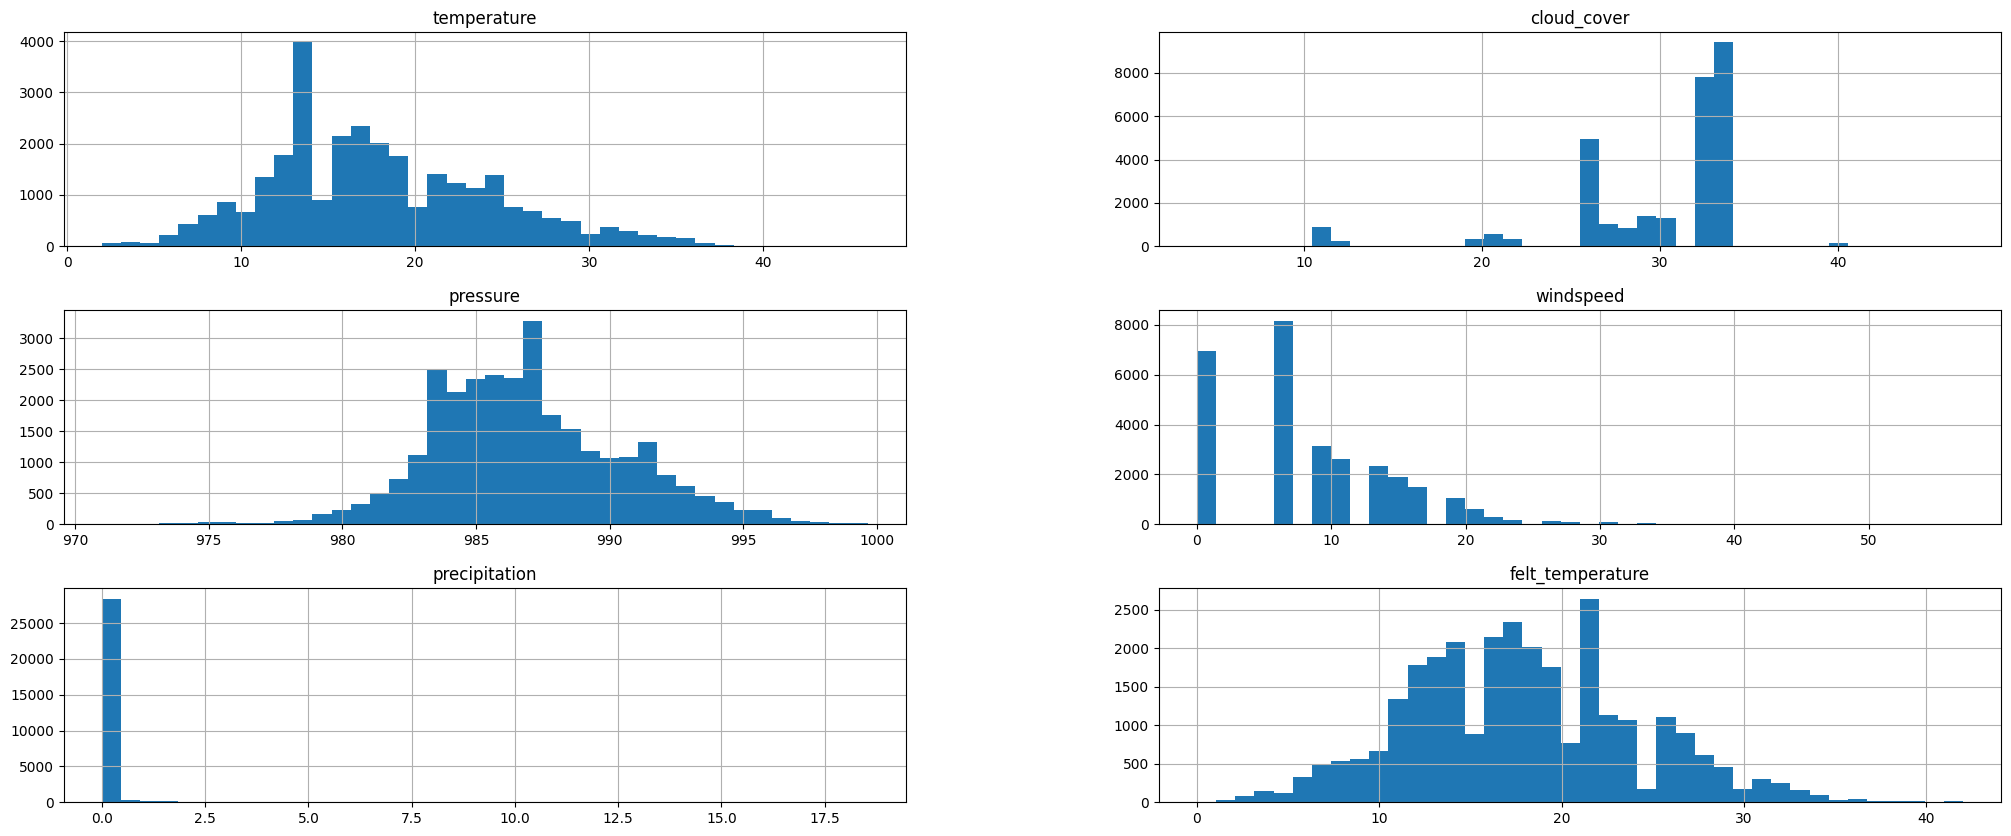

In [ ]:
weather_data.hist(bins=40, figsize=(25,10))